# Biblioteca

In [11]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister 
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import svd
import numpy as np
import random

# Quantum State Preparation - QSP

In [12]:
# Função para preparar o estado de modo recursivo
def prepare_state(circuit, state, qubits):

    n = len(qubits)  # Número de qubits

    # Caso base: Se tivermos apenas dois qubits, usamos initialize.
    if n == 1:
        circuit.initialize(state, qubits)
        return

    k = n // 2  # Dividir o número de qubits pela metade

    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    state = state.reshape((dim1, dim2))  # Reshape para matriz retangular

    # Decomposição SVD para obter coeficientes de Schmidt e unitários
    U, singular_values, V_dag = svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)  # Normalizar

    # Prepara o estado no primeiro subespaço
    prepare_state(circuit, singular_values, qubits[:k])

    # Fase 2: Aplicar CNOT entre os dois subespaços
    for i in range(k):
        circuit.cx(qubits[i], qubits[i + k])

    # Fase 3: Aplicar o unitário no primeiro subespaço
    U_gate = UnitaryGate(U, label="U")
    circuit.append(U_gate, qubits[:k])

    # Fase 4: Aplicar o unitário no segundo subespaço
    V_gate = UnitaryGate(V_dag.T.conj(), label="V†")
    circuit.append(V_gate, qubits[k:])

In [13]:
# Função para preparar um estado quântico arbitrário
def prepare_arbitrary_state(n, state):

    # Inicializar o circuito
    qc = QuantumCircuit(n)

    # Preparar o estado
    prepare_state(qc, state, list(range(n)))

    return qc

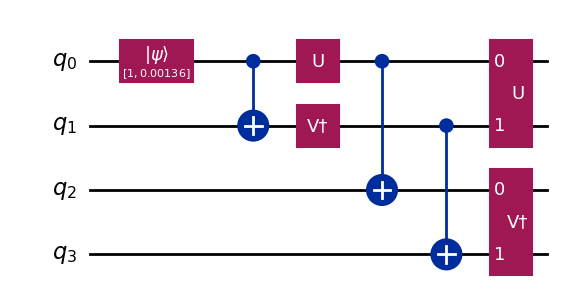

In [14]:
n_qubits = 4  # Teste com número ímpar
target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
target_state = target_state / np.linalg.norm(target_state)  # Normalizar

# Gerar o circuito
circuit = prepare_arbitrary_state(n_qubits, target_state)

# Exibir o circuito
circuit.draw('mpl')

In [15]:
measure = circuit.copy()

# Simular o circuito
measure.measure_all()

sampler = Sampler()

job = sampler.run([measure])
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'1101': 107, '0000': 32, '1001': 28, '0111': 81, '1011': 70, '0011': 4, '1110': 117, '1010': 62, '1111': 58, '1000': 41, '0001': 77, '1100': 142, '0010': 68, '0101': 91, '0110': 25, '0100': 21}


# Quantum Error Correction - QEC

In [46]:
def measure_current_state(qc, n):
    measure = qc.copy()
        
    measurer = ClassicalRegister(n, "measurer")
    measure.add_register(measurer)
    
    for i in range(n):
        measure.measure(i, measurer[i])

    sampler = Sampler()
    
    job = sampler.run([measure])
    result = job.result()
    
    print(result[0].data.measurer.get_counts()) 
    
    print("")

In [79]:
# Função para codificar um qubit usando o código de Shor
def encode_qubit(qc, n):
    # Adiciona 8 qubits extras para codificação com um nome único
    extra_qubits = QuantumRegister(8*n, name="extra_q")  # Registro adicional com nome único
    qc.add_register(extra_qubits)  # Adiciona o registro ao circuito
     
    for i in range(n):        
        qc.cx(i,8*i + 3 + (n-1))
        qc.cx(i,8*i + 6 + (n-1))

        measure_current_state(qc, 9)

        qc.h(i)
        qc.h(8*i + 3 + (n-1))
        qc.h(8*i + 6 + (n-1))

        measure_current_state(qc, 9)

        qc.cx(i,8*i + 1 + (n-1))
        qc.cx(8*i + 3 + (n-1),8*i + 4 + (n-1))
        qc.cx(8*i + 6 + (n-1),8*i + 7 + (n-1))

        qc.cx(i,8*i + 2 + (n-1))
        qc.cx(8*i + 3 + (n-1),8*i + 5 + (n-1))
        qc.cx(8*i + 6 + (n-1),8*i + 8 + (n-1))
        
        qc.barrier()

    return qc

In [57]:
def apply_random_error(qc, n):
    error_qubit = random.randint(0, (n*9)-1)
    
    error_type = random.choice(['x', 'z'])
    if error_type == 'x':
        qc.x(error_qubit)
    else:
        qc.z(error_qubit)

    qc.barrier()
    return qc

In [117]:
def correct_error(circuit, n):

    for i in range(n): 
        circuit.cx(i,i*8 + n) #
        circuit.cx(i*8 + n + 2,i*8 + n + 3) #
        circuit.cx(i*8 + n + 5,i*8 + n + 6) #

        circuit.cx(i,i*8 + n + 1) #
        circuit.cx(i*8 + n + 2,i*8 + n + 4) #
        circuit.cx(i*8 + n + 5,i*8 + n + 7) #  

        circuit.ccx(i*8 + n,i*8 + n + 1,i) #
        circuit.ccx(i*8 + n + 4,i*8 + n + 3,i*8 + n + 2) 
        circuit.ccx(i*8 + n + 7,i*8 + n + 6,i*8 + n + 5) 

        measure_current_state(circuit, 9)

        circuit.h(i) #
        circuit.h(i*8 + n + 2)
        circuit.h(i*8 + n + 5)

        measure_current_state(circuit, 9)

        circuit.cx(i,i*8 + n + 2) 
        circuit.cx(i,i*8 + n + 5) 
        circuit.ccx(i*8 + n + 5,i*8 + n + 2,i) 

        circuit.barrier()  # Adiciona barreira
    
    return circuit

In [90]:
def qec(circuit, n_qubits):

    ###########################################
    print("Estados iniciais:")
    measure_current_state(circuit, n_qubits)
    
    ###########################################
    # Código de Shor
    encode_qubit(circuit, n_qubits)

    print("Estados pós codificação de Shor:")
    measure_current_state(circuit, n_qubits*9)

    ###########################################
    # Aplicar erro
    apply_random_error(circuit, n_qubits)

    print("Estados pós aplicação de erro:")
    measure_current_state(circuit, n_qubits*9)

    ###########################################
    # Correção dos erros
    print("Estados pós correção de erro:")
    correct_error(circuit, n_qubits)
    measure_current_state(circuit, n_qubits*9)

    ###########################################
    # Aplicação da Hadamard transversal
    # (Preserva a codificação sem decodificar)
    hadamard_circuit = circuit.copy()
    for block in range(n_qubits):
        base = block * 9
        hadamard_circuit.h(range(base, base + 9))
    
    print("Estados pós Hadamard transversal:")
    measure_current_state(hadamard_circuit, n_qubits*9)
    
    ###########################################    
    print("Estados finais:")
    measure_current_state(circuit, n_qubits)

    return circuit

Estados iniciais:
{'0': 730, '1': 294}

{'000000000': 726, '001001001': 298}

{'000001001': 225, '001001001': 17, '000001000': 17, '001001000': 242, '000000000': 249, '001000001': 243, '001000000': 17, '000000001': 14}

Estados pós codificação de Shor:
{'000111111': 251, '111000111': 243, '111111000': 210, '000000000': 260, '000000111': 14, '111111111': 19, '111000000': 14, '000111000': 13}

Estados pós aplicação de erro:
{'101000111': 245, '010111111': 239, '101111000': 245, '010000000': 240, '101000000': 12, '010111000': 17, '010000111': 12, '101111111': 14}

Estados pós correção de erro:
{'010000000': 258, '010001001': 239, '011000001': 214, '011001000': 244, '010000001': 16, '011000000': 19, '010001000': 15, '011001001': 19}

{'010000000': 735, '011001001': 289}

{'010000001': 288, '010000000': 736}

Estados pós Hadamard transversal:
{'110110000': 3, '000010000': 5, '110110010': 7, '001101010': 4, '001100000': 4, '100011010': 6, '010111000': 3, '011011000': 5, '110011110': 4, '1111

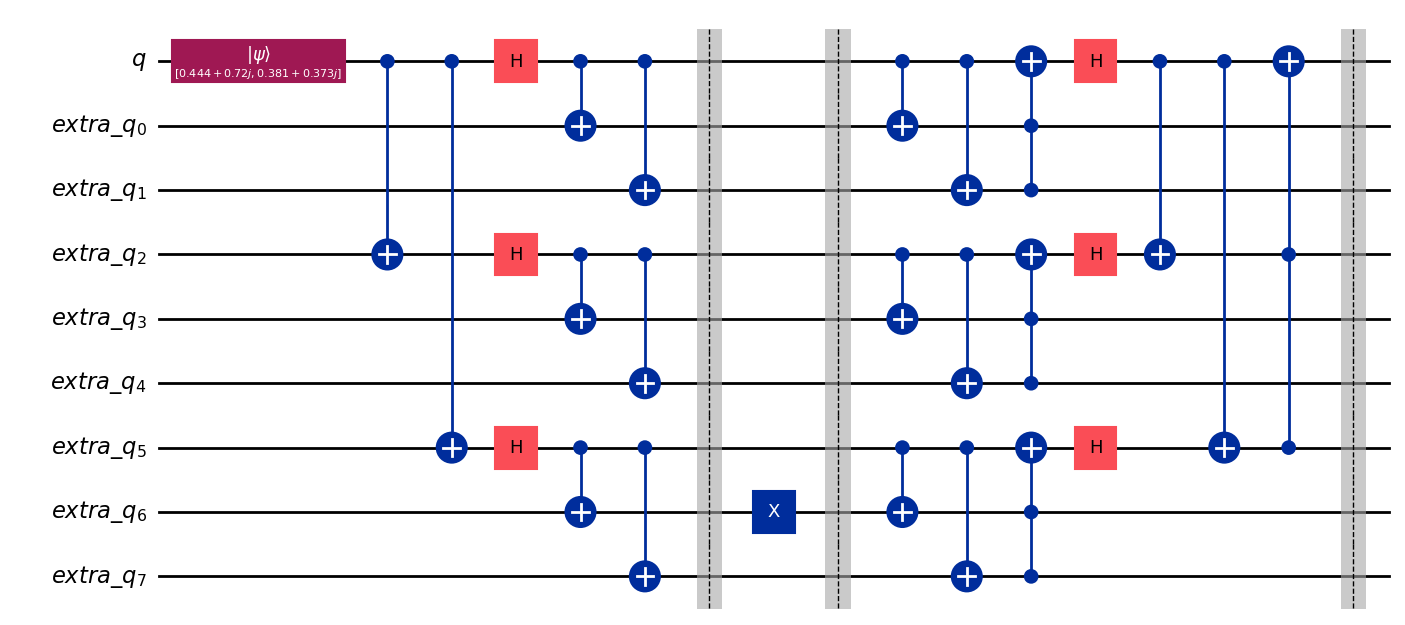

In [121]:
n_qubits = 1  # Teste com número ímpar
target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
target_state = target_state / np.linalg.norm(target_state)  # Normalizar

# Gerar o circuito
circuit = prepare_arbitrary_state(n_qubits, target_state)

qec(circuit, n_qubits)

circuit.draw(output='mpl')

# Exibir o circuito
circuit.draw('mpl')